## Time-resolved single-gene analyses

### 1 Prepare data

Write part of the directory listing to a variable:

In [1]:
import platform

files = !ls ../results/volume*

Set up a dictionary that contains the simulation results.

In [2]:
import re

filepaths = {}
for file in files:
    match = re.search(r'from (\w+)', file)
    if match:
        filepaths[int(match.group(1).zfill(4))] = file

Function to replace _numpypy.multiarray by numpy.core.multiarray. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [3]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

Port from Pypy to Python:

In [4]:
for time in filepaths:
    print time,
    #replace(filepaths[time], "_numpypy.multiarray", "numpy.core.multiarray")

0 2400 3300 1800 300 2700 1200 600 2100 3000 900 1500


In [5]:
import cPickle as pkl

results = {}
proteome = {}
for time in filepaths:
    print time, filepaths[time]
    results[time] = pkl.load(open(filepaths[time]))
    proteome[time] = {key: results[time]['proteome'][key] for key in results[time]['proteome'] 
                     if results[time]['proteome'][key] > 1e-2}

0 ../results/volume-adjusted polyphasic cell cycle from 0 to 300, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20160804_1452_1200s.p
2400 ../results/volume-adjusted polyphasic cell cycle from 2400 to 2700, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20160804_1741_1200s.p
3300 ../results/volume-adjusted polyphasic cell cycle from 3300 to 3600, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20160804_1845_1200s.p
1800 ../results/volume-adjusted polyphasic cell cycle from 1800 to 2100, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20160804_1655_1200s.p
300 ../results/volume-adjusted polyphasic cell cycle from 300 to 600, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Sh

### 2 Test burn-in period

Plot timecourses:

In [6]:
import numpy as np
import random

time = 300  # any cell cycle time shuld be tested in theory
protnames = results[time]['timecourses'].keys()
size = 5
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

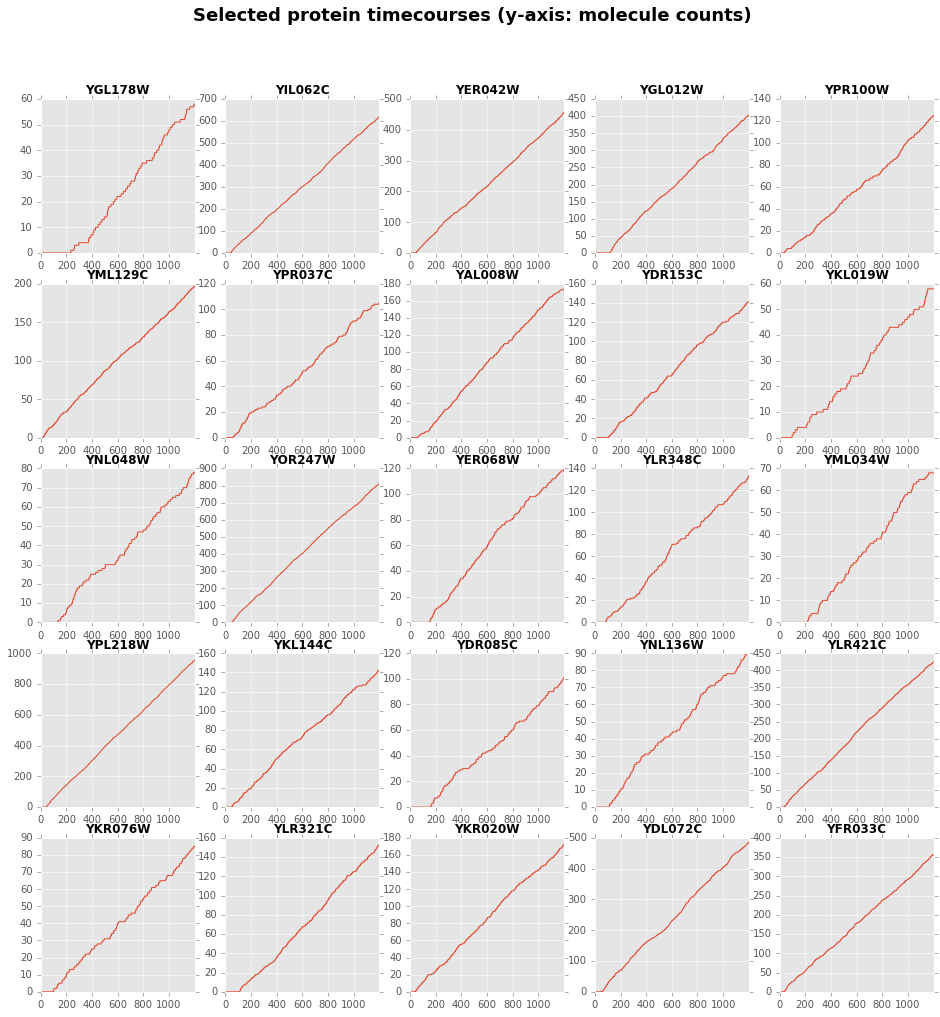

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

fig, ax = plt.subplots(size, size, figsize=(16, 16))

plt.suptitle('Selected protein timecourses (y-axis: molecule counts)', fontsize=18, fontweight='bold')

for i in range(size):
    for j in range(size):
        yseries = results[time]['timecourses'][protnames_plot[i][j]]
        xseries = np.arange(0., float(len(yseries)), 1.)
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].plot(xseries[:length], yseries[:length])
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 200.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=10)

### 3 Single-gene analysis

In [32]:
genes_shortlist = {'HHF1': 'YBR009C', 'HHF2': 'YNL030W', 'HHT1': 'YBR010W', 'HHT2': 'YNL031C', 'HTB1': 'YDR224C', 
                   'HTB2': 'YBL002W', # 'PMA1': 'YGL008C', 
                   # 'RNR1': 'YER070W', 'RNR2': 'YJL026W', 'RNR3': 'YIL066C', 'RNR4': 'YGR180C', 
                   # genes suggested by Katja, some histones
                   'SIC1': 'YLR079W', 'CLN2': 'YPL256C', 'CLB2': 'YPR119W', 'CLB5': 'YPR120C', 
                   'PCL1': 'YNL289W', 'PCL9': 'YDL179W', 'SWE1': 'YJL187C'} # FISH genes

In [33]:
translation_rate_shortlist = {}

for (genecommon, gene) in genes_shortlist.items():
    translation_rate_shortlist[genecommon] = []
    for time in np.arange(0, 3600, 300):
        if gene in results[time]['timecourses']:
            rate = float(results[time]['timecourses'][gene][-1]-results[time]['timecourses'][gene][-601])/600.
        else:
            rate = 0.
        translation_rate_shortlist[genecommon].append(rate)

In [34]:
import pandas as pd

translation_ratedf = pd.DataFrame(translation_rate_shortlist, index=np.arange(0, 3600, 300))

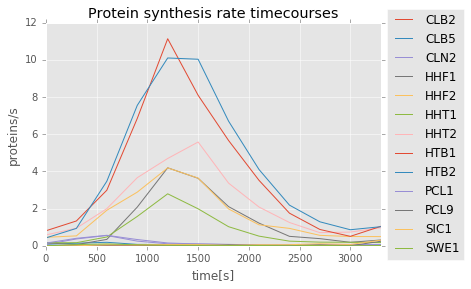

In [35]:
pl = translation_ratedf.plot(title="Protein synthesis rate timecourses")

pl.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
pl.set_xlabel("time[s]")
pl.set_ylabel("proteins/s")

For these genes, find mRNA time courses:

In [36]:
import collections

transcriptomes_dict = collections.OrderedDict(sorted(
        pkl.load((open('../parameters/transcriptome_time_dependent.p'))).items()))

In [37]:
transcriptomes_df = pd.DataFrame(transcriptomes_dict).transpose()

In [38]:
transcriptomes_df.set_index(np.arange(0, 3601, 300), inplace=True)

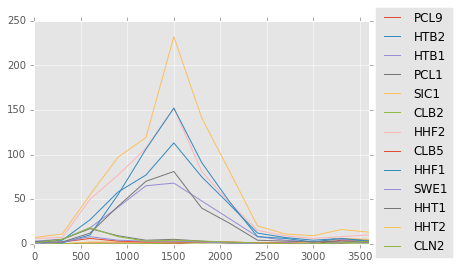

In [48]:
transcriptomes_short_df = transcriptomes_df[genes_shortlist.values()]
transcriptomes_short_df.columns = genes_shortlist.keys()
transcriptomes_short_df.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [74]:
transcriptomes_short_df = transcriptomes_short_df[['CLB2', 'CLB5', 'CLN2', 'PCL1', 'PCL9', 'SIC1', 'SWE1', 
                                                   #'HHF1', 'HHF2', 'HHT1', 'HHT2', # no initiation rates
                                                   'HTB1', 'HTB2']]
transcriptomes_short_df

,CLB2,CLB5,CLN2,PCL1,PCL9,SIC1,SWE1,HTB1,HTB2
0,0,1,1,2,0,0,0,3,2
300,0,2,5,5,0,0,2,5,4
600,0,6,18,17,1,2,8,18,27
900,0,3,8,9,1,2,4,41,58
1200,0,2,3,4,1,2,3,65,77
1500,1,2,4,5,0,3,3,68,113
1800,1,2,3,3,2,1,2,48,75
2100,1,2,2,1,1,2,1,28,44
2400,0,1,1,0,0,1,0,8,12
2700,0,1,0,1,1,2,1,4,7


In [75]:
translation_ratedf

,CLB2,CLB5,CLN2,HHF1,HHF2,HHT1,HHT2,HTB1,HTB2,PCL1,PCL9,SIC1,SWE1
0,0.000000,0.085000,0.070000,0.163333,0.456667,0.165000,0.583333,0.808333,0.425000,0.146667,0.000000,0.000000,0.000000
300,0.000000,0.136667,0.368333,0.063333,0.533333,0.166667,0.946667,1.335000,0.935000,0.403333,0.000000,0.000000,0.063333
600,0.000000,0.188333,0.553333,0.343333,1.910000,0.473333,1.996667,2.988333,3.470000,0.565000,0.038333,0.056667,0.101667
900,0.000000,0.075000,0.251667,2.080000,2.885000,1.578333,3.661667,6.846667,7.550000,0.336667,0.045000,0.055000,0.055000
1200,0.000000,0.068333,0.106667,4.193333,4.188333,2.795000,4.695000,11.131667,10.098333,0.151667,0.041667,0.071667,0.025000
1500,0.021667,0.030000,0.103333,3.630000,3.640000,1.988333,5.580000,8.091667,10.030000,0.095000,0.000000,0.066667,0.025000
1800,0.020000,0.033333,0.076667,2.106667,1.981667,1.026667,3.370000,5.661667,6.701667,0.065000,0.060000,0.025000,0.020000
2100,0.016667,0.046667,0.048333,1.220000,1.128333,0.520000,2.085000,3.520000,4.103333,0.020000,0.030000,0.056667,0.015000
2400,0.000000,0.050000,0.048333,0.508333,0.936667,0.250000,1.253333,1.755000,2.186667,0.000000,0.000000,0.060000,0.000000
2700,0.000000,0.058333,0.000000,0.385000,0.561667,0.196667,0.706667,0.878333,1.290000,0.055000,0.058333,0.108333,0.021667


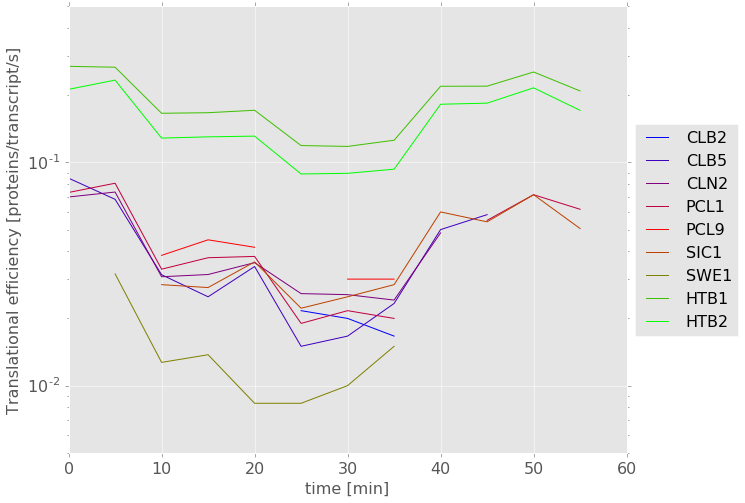

In [80]:
plt.rcParams['figure.figsize'] = (10, 8)

ratio = translation_ratedf.div(transcriptomes_short_df)[['CLB2', 'CLB5', 'CLN2', 'PCL1', 'PCL9', 'SIC1', 'SWE1', 
                                                         #'HHF1', 'HHF2', 'HHT1', 'HHT2', 
                                                         'HTB1', 'HTB2']]
ratio.set_index(np.arange(0, 61, 5), inplace=True)
ax = ratio.plot(logy=True, ylim=[5e-3, 5e-1], colormap='brg')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
ax.set_xlabel("time [min]", fontsize=16)
ax.set_ylabel("Translational efficiency [proteins/transcript/s]", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

In [81]:
init_rates = pkl.load(open("../parameters/init_rates_plotkin.p", "rb"))

In [82]:
for gene in ['CLB2', 'CLB5', 'CLN2', 'PCL1', 'PCL9', 'SIC1', 'SWE1', 'HHF1', 'HHF2', 'HHT1', 'HHT2', 'HTB1', 
             'HTB2']:
    if genes_shortlist[gene] in init_rates:
        print gene, genes_shortlist[gene], init_rates[genes_shortlist[gene]]

CLB2 YPR119W 1.07863479792e-06
CLB5 YPR120C 1.08393456684e-06
CLN2 YPL256C 1.07536488822e-06
PCL1 YNL289W 1.27382287498e-06
PCL9 YDL179W 1.42121527966e-06
SIC1 YLR079W 1.15695247462e-06
SWE1 YJL187C 3.75113962529e-07
HTB1 YDR224C 8.58045121193e-06
HTB2 YBL002W 5.73892764002e-06
